## Load Dataset

### Mount with Drive

In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
# import os

# folder_path = "/content/drive/My Drive/image_ai/SkinCancerClassification/SkinCancerClassification"


# if os.path.exists(folder_path):
#     print("Folder exists!")
# else:
#     print("Folder not found. Check the path.")

Folder exists!


In [ ]:
# train_dir = '/content/drive/My Drive/image_ai/SkinCancerClassification/SkinCancerClassification/Train'
# test_dir = '/content/drive/My Drive/image_ai/SkinCancerClassification/SkinCancerClassification/Test'


### Local Path

In [1]:
import os

folder_path = "SkinCancerClassification"


if os.path.exists(folder_path):
    print("Folder exists!")
else:
    print("Folder not found. Check the path.")

Folder exists!


In [2]:
train_dir = 'SkinCancerClassification/Train'
test_dir = 'SkinCancerClassification/Test'
augmented_dir = 'SkinCancerClassification/Augmented_Train'

### Load & Display images per class

Image Counts per Class:
actinic keratosis: 114
basal cell carcinoma: 376
dermatofibroma: 95
melanoma: 438
nevus: 357
pigmented benign keratosis: 462
seborrheic keratosis: 77
squamous cell carcinoma: 181
vascular lesion: 139


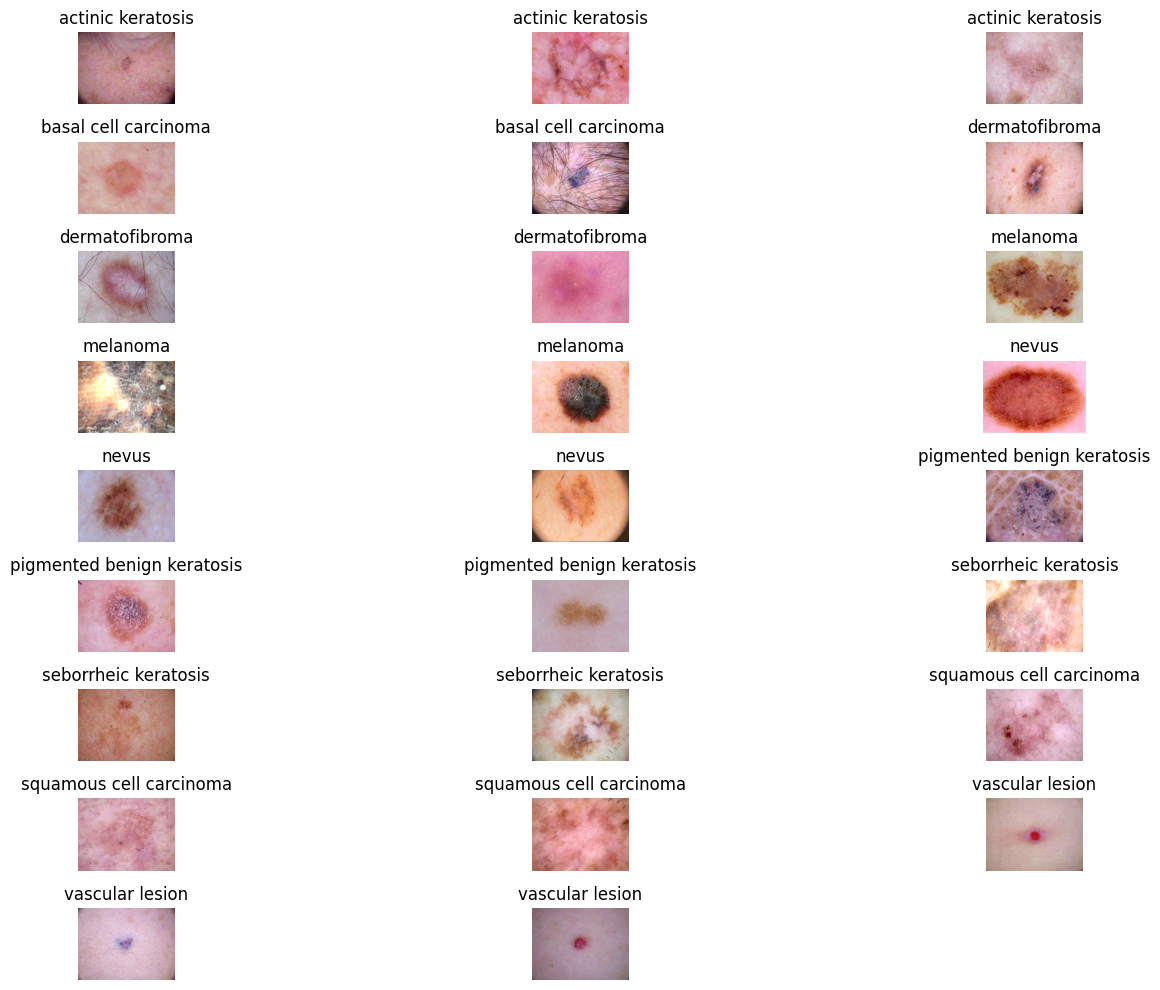

In [10]:
import os
import matplotlib.pyplot as plt
from PIL import Image

class_counts = {}
sample_images = {}

for class_name in sorted(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [img for img in os.listdir(class_path) if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    class_counts[class_name] = len(images)
    sample_images[class_name] = images[:3]  # Take 3 samples per class

# Show class-wise counts
print("Image Counts per Class:")
for cls, count in class_counts.items():
    print(f"{cls}: {count}")

# Display some sample images
plt.figure(figsize=(15, 10))
i = 1
for cls, imgs in sample_images.items():
    for img_name in imgs:
        img_path = os.path.join(train_dir, cls, img_name)
        try:
            img = Image.open(img_path)
            plt.subplot(len(sample_images), 3, i)
            plt.imshow(img)
            plt.title(cls)
            plt.axis('off')
            i += 1
        except:
            continue

plt.tight_layout()
plt.show()


## Preprocess Dataset

### Find Remove Corrupt Images

In [11]:
from PIL import UnidentifiedImageError

def remove_corrupt_images(directory):
    removed = 0
    for root, _, files in os.walk(directory):
        for filename in files:
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(root, filename)
                try:
                    with Image.open(file_path) as img:
                        img.verify()  # This will throw an error if image is corrupted
                except (UnidentifiedImageError, OSError, IOError):
                    os.remove(file_path)
                    removed += 1
                    print(f"Removed corrupt image: {file_path}")
    print(f"\nTotal removed: {removed} corrupt images")

remove_corrupt_images(train_dir)


Removed corrupt image: SkinCancerClassification/Train/pigmented benign keratosis/ISIC_0027680.jpg
Removed corrupt image: SkinCancerClassification/Train/pigmented benign keratosis/ISIC_0026867.jpg
Removed corrupt image: SkinCancerClassification/Train/pigmented benign keratosis/ISIC_0024626.jpg
Removed corrupt image: SkinCancerClassification/Train/pigmented benign keratosis/ISIC_0025777.jpg
Removed corrupt image: SkinCancerClassification/Train/pigmented benign keratosis/ISIC_0027770.jpg
Removed corrupt image: SkinCancerClassification/Train/pigmented benign keratosis/ISIC_0027151.jpg
Removed corrupt image: SkinCancerClassification/Train/pigmented benign keratosis/ISIC_0028449.jpg
Removed corrupt image: SkinCancerClassification/Train/actinic keratosis/ISIC_0026171.jpg
Removed corrupt image: SkinCancerClassification/Train/actinic keratosis/ISIC_0030036.jpg
Removed corrupt image: SkinCancerClassification/Train/actinic keratosis/ISIC_0030730.jpg
Removed corrupt image: SkinCancerClassification

### Augment Dataset

Augmentation Techniques used:
* Random Flip, Rotation, Zoom, Translation
* Random Contrast
* Perlin Noise
* Voronoi Noise
* Random Skew
* Color Temperature Shift

In [13]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.preprocessing.image import img_to_array, load_img, save_img
from PIL import Image

# Set constants
TARGET_COUNT = 3000
IMAGE_SIZE = (224, 224)
train_dir = 'SkinCancerClassification/Train'
augmented_dir = 'SkinCancerClassification/Augmented_Train'

# Data Augmentation Sequential model
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomTranslation(0.1, 0.1),
    tf.keras.layers.RandomContrast(0.3)
])

# Perlin noise generator
def perlin_noise(shape=(224, 224), scale=10):
    def f(t):
        return 6 * t**5 - 15 * t**4 + 10 * t**3
    delta = scale / min(shape)
    d = (shape[0] // scale, shape[1] // scale)
    grid = np.random.rand(d[0]+1, d[1]+1, 2) * 2 - 1
    xs = np.linspace(0, scale, shape[0], endpoint=False)
    ys = np.linspace(0, scale, shape[1], endpoint=False)
    xi = xs.astype(int)
    yi = ys.astype(int)
    xf = f(xs - xi)
    yf = f(ys - yi)
    n00 = np.sum(grid[xi, yi] * np.stack([xf, yf], -1), axis=-1)
    n10 = np.sum(grid[xi+1, yi] * np.stack([xf-1, yf], -1), axis=-1)
    n01 = np.sum(grid[xi, yi+1] * np.stack([xf, yf-1], -1), axis=-1)
    n11 = np.sum(grid[xi+1, yi+1] * np.stack([xf-1, yf-1], -1), axis=-1)
    x1 = n00 + xf * (n10 - n00)
    x2 = n01 + xf * (n11 - n01)
    result = (x1 + yf * (x2 - x1))
    result = (result - result.min()) / (result.max() - result.min())
    return result[..., np.newaxis]

# Voronoi-like noise approximation (using random blobs)
def voronoi_noise(shape=(224, 224), points=50):
    noise = np.zeros(shape, dtype=np.float32)
    pts = np.random.randint(0, min(shape), size=(points, 2))
    yy, xx = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), indexing='ij')
    for p in pts:
        dist = np.sqrt((yy - p[0])**2 + (xx - p[1])**2)
        noise = np.maximum(noise, np.exp(-dist / 40))  # adjust 40 for sharpness
    noise = (noise - noise.min()) / (noise.max() - noise.min())
    return noise[..., np.newaxis]

# Random skew transform
def random_skew_tf(image, magnitude=0.2):
    h, w, c = image.shape
    skew_x = tf.random.uniform([], -magnitude, magnitude)
    skew_y = tf.random.uniform([], -magnitude, magnitude)
    transform = tf.convert_to_tensor([1.0, skew_x, 0.0,
                                      skew_y, 1.0, 0.0,
                                      0.0, 0.0], dtype=tf.float32)
    transform = tf.reshape(transform, (1, 8))
    image = tf.raw_ops.ImageProjectiveTransformV3(
        images=tf.expand_dims(image, 0),
        transforms=transform,
        output_shape=[h, w],
        interpolation="BILINEAR",
        fill_value=0.0
    )[0]
    return image

# Color temperature shift
def adjust_color_temperature(image, delta=5):
    r, g, b = tf.split(image, 3, axis=-1)
    r = tf.clip_by_value(r + delta/255., 0., 1.)
    b = tf.clip_by_value(b - delta/255., 0., 1.)
    return tf.concat([r, g, b], axis=-1)

# Process each class
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # Create equivalent folder in augmented_dir
    augmented_class_path = os.path.join(augmented_dir, class_name)
    os.makedirs(augmented_class_path, exist_ok=True)

    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    current_count = len(image_files)
    print(f"\nProcessing '{class_name}' | Current: {current_count}")

    # Copy original images first
    for img_file in image_files:
        original_img_path = os.path.join(class_path, img_file)
        new_original_path = os.path.join(augmented_class_path, img_file)
        if not os.path.exists(new_original_path):
            img = load_img(original_img_path, target_size=IMAGE_SIZE)
            save_img(new_original_path, img_to_array(img).astype(np.uint8))

    if current_count >= TARGET_COUNT:
        print("Already has enough images.")
        continue

    augment_needed = TARGET_COUNT - current_count
    generated, i = 0, 0
    while generated < augment_needed:
        img_path = os.path.join(class_path, image_files[i % current_count])
        try:
            img = load_img(img_path, target_size=IMAGE_SIZE, color_mode='rgb')
            x = img_to_array(img) / 255.0
            x = tf.convert_to_tensor(x)

            x_aug = data_augmentation(tf.expand_dims(x, 0))[0]
            x_aug = tf.image.random_brightness(x_aug, max_delta=0.2)
            x_aug = random_skew_tf(x_aug)

            delta = tf.random.uniform([], -30, 30)
            x_aug = adjust_color_temperature(x_aug, delta)
            perlin = perlin_noise(IMAGE_SIZE)
            voronoi = voronoi_noise(IMAGE_SIZE)

            x_aug = tf.clip_by_value(x_aug + 0.04 * perlin + 0.04 * voronoi, 0., 1.)
            aug_img_uint8 = tf.image.convert_image_dtype(x_aug, dtype=tf.uint8)

            new_aug_img_path = os.path.join(augmented_class_path, f"aug_{generated}_{image_files[i % current_count]}")
            save_img(new_aug_img_path, aug_img_uint8.numpy())

            generated += 1
            if generated >= augment_needed:
                break

        except Exception as e:
            print(f"Error processing image {img_path}: {e}")

        i += 1

    print(f"Augmented {generated} images for '{class_name}'")

print("\nAll augmentation and copying complete.")



Processing 'pigmented benign keratosis' | Current: 455
Augmented 2545 images for 'pigmented benign keratosis'

Processing 'actinic keratosis' | Current: 107
Augmented 2893 images for 'actinic keratosis'

Processing 'basal cell carcinoma' | Current: 369
Augmented 2631 images for 'basal cell carcinoma'

Processing 'nevus' | Current: 350
Augmented 2650 images for 'nevus'

Processing 'squamous cell carcinoma' | Current: 174
Augmented 2826 images for 'squamous cell carcinoma'

Processing 'vascular lesion' | Current: 132
Augmented 2868 images for 'vascular lesion'

Processing 'dermatofibroma' | Current: 88
Augmented 2912 images for 'dermatofibroma'

Processing 'melanoma' | Current: 431
Augmented 2569 images for 'melanoma'

Processing 'seborrheic keratosis' | Current: 70
Augmented 2930 images for 'seborrheic keratosis'

All augmentation and copying complete.


In [3]:
train_dir = augmented_dir
print("\n📊 Final Image Counts After Augmentation:\n")
final_counts = {}
for class_name in sorted(os.listdir(train_dir)):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))])
        final_counts[class_name] = count
        print(f"{class_name}: {count}")



📊 Final Image Counts After Augmentation:

actinic keratosis: 3000
basal cell carcinoma: 3000
dermatofibroma: 3000
melanoma: 3000
nevus: 3000
pigmented benign keratosis: 3000
seborrheic keratosis: 3000
squamous cell carcinoma: 3000
vascular lesion: 3000


## Visualize Dataset after Augmentation

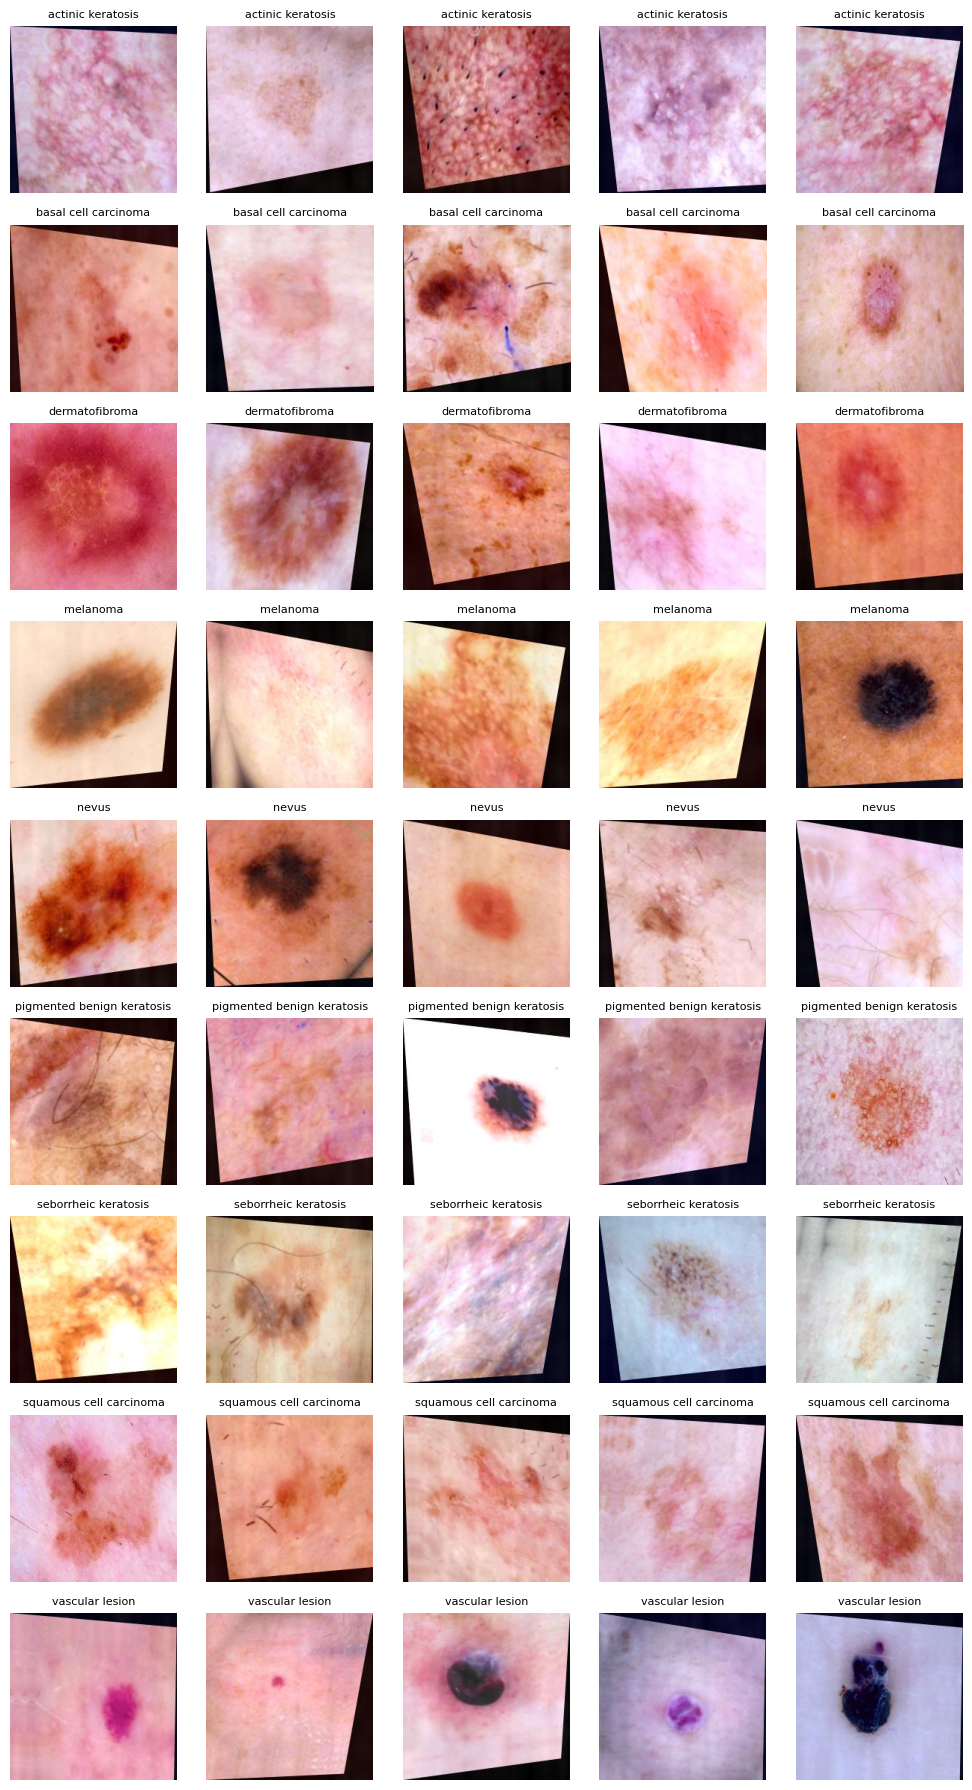

In [15]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image


# Get list of class directories
class_names = sorted(os.listdir(train_dir))

# Number of images to show per class
num_images_per_class = 5

# Set up matplotlib grid
plt.figure(figsize=(num_images_per_class * 2, len(class_names) * 2))

img_index = 1

for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    # List image files (including augmented ones)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

    # Pick random images
    sample_images = random.sample(image_files, min(num_images_per_class, len(image_files)))

    for img_name in sample_images:
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)

        plt.subplot(len(class_names), num_images_per_class, img_index)
        plt.imshow(img)
        plt.title(class_name, fontsize=8)
        plt.axis('off')

        img_index += 1

plt.tight_layout()
plt.show()

## Train Validation Split

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_height, img_width = 224, 224  # You can change this based on your dataset
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


2025-05-20 08:19:01.341369: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747729141.456276     596 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747729141.487718     596 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747729141.736701     596 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747729141.736727     596 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747729141.736728     596 computation_placer.cc:177] computation placer alr

Found 21600 images belonging to 9 classes.
Found 5400 images belonging to 9 classes.


## Baseline CNN Model

In [5]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers


## Baseline with SGD

In [6]:
baseline_SGD_model = Sequential([
    Input(shape=(224,224,3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),

    Dense(64, activation='relu', ),
    Dense(64, activation='relu', ),
    Dense(128, activation='relu', ),
    
    Dense(train_generator.num_classes, activation='softmax')
])


I0000 00:00:1747729261.406043     596 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5592 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6


In [7]:
# Compile the model with SGD optimizer
from tensorflow.keras.optimizers import SGD
baseline_SGD_model.compile(
    optimizer=SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Show model summary
baseline_SGD_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     5,537,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,644,745 (21.53 MB)

 Trainable params: 5,644,745 (21.53 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5 , restore_best_weights=True)

history = baseline_SGD_model.fit(
    train_generator,
    epochs=35,
    validation_data=val_generator,
    callbacks=[early_stop]
)

Epoch 1/35


/home/sanil/py3.11-tensorflow/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1747729329.891652     748 service.cc:152] XLA service 0x7f439400cd10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747729329.891752     748 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-05-20 08:22:09.941023: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1747729330.078564     748 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-20 08:22:12.714610: I external/

  5/675 ━━━━━━━━━━━━━━━━━━━━ 21s 33ms/step - accuracy: 0.1218 - loss: 2.1981

I0000 00:00:1747729337.089290     748 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


674/675 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.1171 - loss: 2.1949

2025-05-20 08:22:47.792293: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_126', 4 bytes spill stores, 4 bytes spill loads



675/675 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - accuracy: 0.1172 - loss: 2.1948 - val_accuracy: 0.1741 - val_loss: 2.1036
Epoch 2/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.2373 - loss: 1.9829 - val_accuracy: 0.2983 - val_loss: 1.8134
Epoch 3/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.2900 - loss: 1.8045 - val_accuracy: 0.3780 - val_loss: 1.6019
Epoch 4/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.3375 - loss: 1.6924 - val_accuracy: 0.3628 - val_loss: 1.6286
Epoch 5/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.3613 - loss: 1.6301 - val_accuracy: 0.3937 - val_loss: 1.5349
Epoch 6/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.3677 - loss: 1.6085 - val_accuracy: 0.3615 - val_loss: 1.6284
Epoch 7/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.4007 - loss: 1.5341 - val_accuracy: 0.3896 - val_loss: 1.5462
Epoch 8/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.4019 - loss: 1.5070 - val_accurac

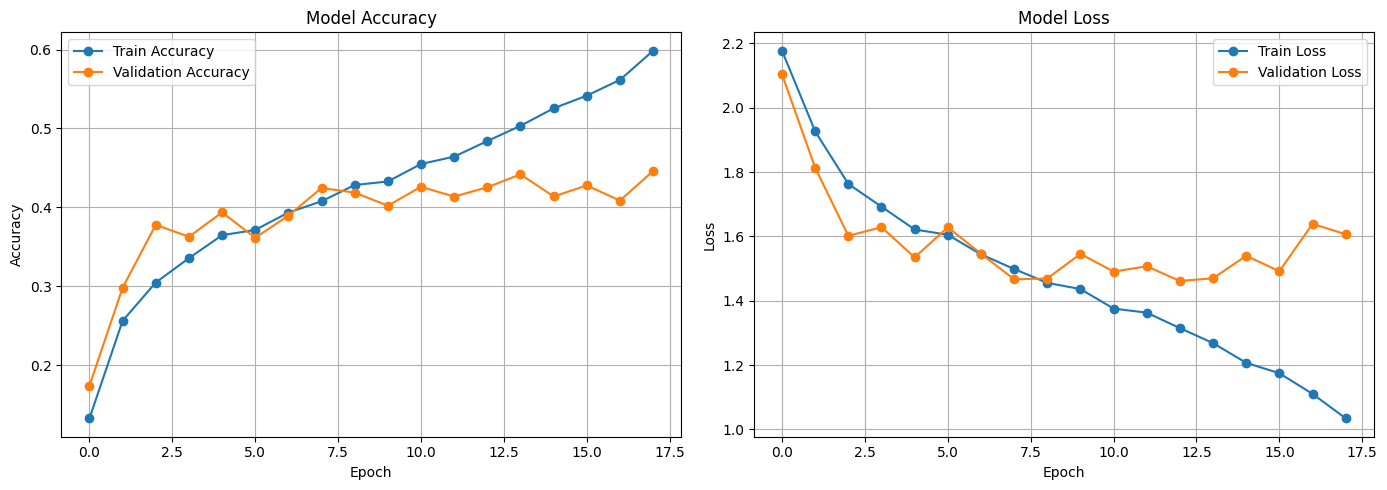

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Baseline with ADAM

In [6]:
baseline_model = Sequential([
    Input(shape=(224,224,3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),

    Flatten(),

    Dense(64, activation='relu', ),
    Dense(64, activation='relu', ),
    Dense(128, activation='relu', ),
    
    Dense(train_generator.num_classes, activation='softmax')
])


I0000 00:00:1746965951.965925     865 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5592 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.6


In [7]:
# Compile the model with optimal hyperparameters
baseline_model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Best starting point for image tasks
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Show model summary
baseline_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     5,537,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,644,745 (21.53 MB)

 Trainable params: 5,644,745 (21.53 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=10 , restore_best_weights=True)

history = baseline_model.fit(
    train_generator,
    epochs=35,
    validation_data=val_generator,
    callbacks=[early_stop]
)


Epoch 1/35


/home/sanil/py3.11-tensorflow/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746965961.572488    1162 service.cc:152] XLA service 0x7f0b9c00ee70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746965961.572555    1162 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-05-11 12:19:21.631297: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746965961.903952    1162 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/675 ━━━━━━━━━━━━━━━━━━━━ 22s 33ms/step - accuracy: 0.1389 - loss: 2.2056

I0000 00:00:1746965968.566034    1162 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


674/675 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.1887 - loss: 2.0520

2025-05-11 12:19:58.883731: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_126', 4 bytes spill stores, 4 bytes spill loads



675/675 ━━━━━━━━━━━━━━━━━━━━ 40s 47ms/step - accuracy: 0.1889 - loss: 2.0515 - val_accuracy: 0.3500 - val_loss: 1.6986
Epoch 2/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.3425 - loss: 1.6846 - val_accuracy: 0.3663 - val_loss: 1.6452
Epoch 3/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.3915 - loss: 1.5824 - val_accuracy: 0.3981 - val_loss: 1.5514
Epoch 4/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.4129 - loss: 1.5131 - val_accuracy: 0.4130 - val_loss: 1.5008
Epoch 5/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.4247 - loss: 1.4836 - val_accuracy: 0.4119 - val_loss: 1.5417
Epoch 6/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.4377 - loss: 1.4556 - val_accuracy: 0.4187 - val_loss: 1.5087
Epoch 7/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.4570 - loss: 1.4290 - val_accuracy: 0.4254 - val_loss: 1.4793
Epoch 8/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 24s 35ms/step - accuracy: 0.4520 - loss: 1.4171 - val_accurac

In [9]:
baseline_model.save("skin_cancer_baseline_model2.h5")

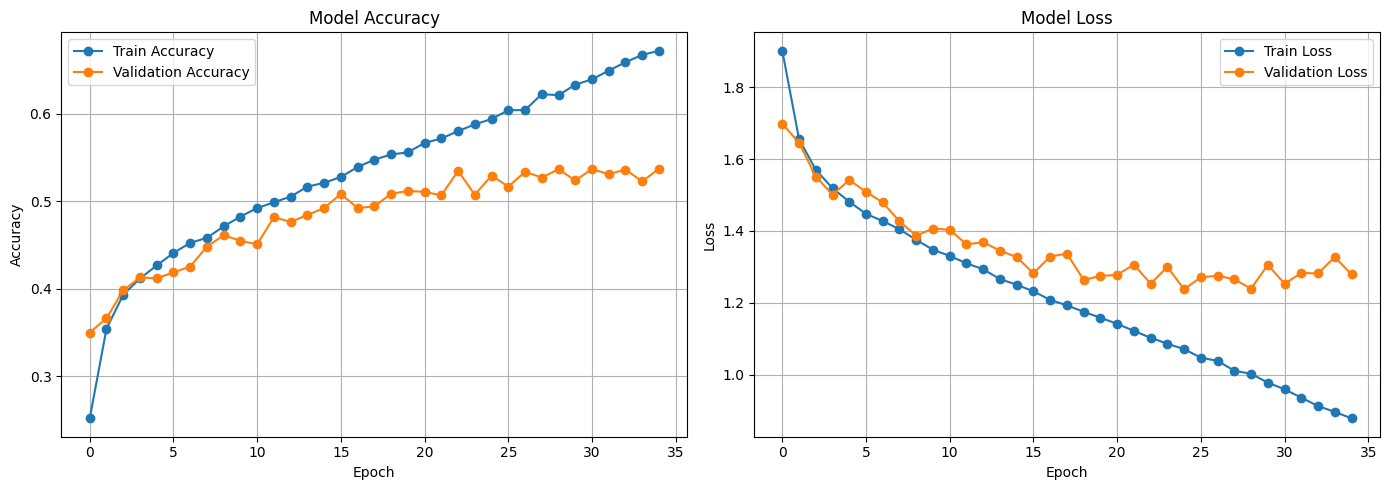

In [10]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Fine Tuned CNN model

In [12]:
model = Sequential([
    Input(shape=(224,224,3)),
    Conv2D(64, (2,2), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),
    Dropout(0.2),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(256, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(512, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Conv2D(1024, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.2),  # One small dropout here
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.2),  # One small dropout here
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.2),  # One small dropout here
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    Dropout(0.2),  # One small dropout here
    Dense(train_generator.num_classes, activation='softmax')
])



In [13]:
# Compile the model with optimal hyperparameters
model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Best starting point for image tasks
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Show model summary
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 223, 223, 64)   │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 111, 111, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 111, 111, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 109, 109, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 54, 54, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 26, 26, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 10, 10, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 5, 5, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 3, 3, 1024)     │     4,719,616 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 1, 1, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 1, 1, 1024)     │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             

 Total params: 7,012,617 (26.75 MB)

 Trainable params: 7,008,521 (26.74 MB)

 Non-trainable params: 4,096 (16.00 KB)

In [14]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=10 , restore_best_weights=True)
checkpoint = ModelCheckpoint(
    filepath='fine_tuned_checkpoint.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)


history = model.fit(
    train_generator,
    epochs=35,
    validation_data=val_generator,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2475 - loss: 3.2494

675/675 ━━━━━━━━━━━━━━━━━━━━ 60s 68ms/step - accuracy: 0.2476 - loss: 3.2492 - val_accuracy: 0.2980 - val_loss: 3.0117
Epoch 2/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3438 - loss: 2.8804

675/675 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.3438 - loss: 2.8804 - val_accuracy: 0.3863 - val_loss: 2.7244
Epoch 3/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3949 - loss: 2.6924

675/675 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.3949 - loss: 2.6923 - val_accuracy: 0.3920 - val_loss: 2.6266
Epoch 4/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4483 - loss: 2.4907

675/675 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.4483 - loss: 2.4906 - val_accuracy: 0.4269 - val_loss: 2.5003
Epoch 5/35
674/675 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4915 - loss: 2.3138

675/675 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.4915 - loss: 2.3137 - val_accuracy: 0.4857 - val_loss: 2.2637
Epoch 6/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5230 - loss: 2.1420

675/675 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.5230 - loss: 2.1420 - val_accuracy: 0.4896 - val_loss: 2.1208
Epoch 7/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5585 - loss: 1.9809

675/675 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.5585 - loss: 1.9809 - val_accuracy: 0.5330 - val_loss: 2.0469
Epoch 8/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5849 - loss: 1.8272

675/675 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.5849 - loss: 1.8272 - val_accuracy: 0.5796 - val_loss: 1.7967
Epoch 9/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.6257 - loss: 1.6755 - val_accuracy: 0.5489 - val_loss: 1.8513
Epoch 10/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.6564 - loss: 1.5429

675/675 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - accuracy: 0.6564 - loss: 1.5429 - val_accuracy: 0.6085 - val_loss: 1.6607
Epoch 11/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.6810 - loss: 1.4227

675/675 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - accuracy: 0.6810 - loss: 1.4227 - val_accuracy: 0.6293 - val_loss: 1.5617
Epoch 12/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7284 - loss: 1.2563

675/675 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - accuracy: 0.7284 - loss: 1.2563 - val_accuracy: 0.6307 - val_loss: 1.5145
Epoch 13/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7572 - loss: 1.1442

675/675 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - accuracy: 0.7572 - loss: 1.1441 - val_accuracy: 0.6378 - val_loss: 1.5124
Epoch 14/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.7876 - loss: 1.0237

675/675 ━━━━━━━━━━━━━━━━━━━━ 43s 64ms/step - accuracy: 0.7876 - loss: 1.0237 - val_accuracy: 0.6472 - val_loss: 1.5108
Epoch 15/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.8223 - loss: 0.9174

675/675 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.8223 - loss: 0.9174 - val_accuracy: 0.6457 - val_loss: 1.5101
Epoch 16/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 41s 61ms/step - accuracy: 0.8482 - loss: 0.8225 - val_accuracy: 0.6500 - val_loss: 1.5389
Epoch 17/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 42s 63ms/step - accuracy: 0.8645 - loss: 0.7603 - val_accuracy: 0.6176 - val_loss: 1.7696
Epoch 18/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - accuracy: 0.8790 - loss: 0.6992 - val_accuracy: 0.6439 - val_loss: 1.6821
Epoch 19/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9040 - loss: 0.6262

675/675 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.9040 - loss: 0.6262 - val_accuracy: 0.6656 - val_loss: 1.4971
Epoch 20/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.9233 - loss: 0.5529 - val_accuracy: 0.6541 - val_loss: 1.5951
Epoch 21/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.9319 - loss: 0.5258 - val_accuracy: 0.6696 - val_loss: 1.5483
Epoch 22/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 42s 62ms/step - accuracy: 0.9427 - loss: 0.4795 - val_accuracy: 0.6828 - val_loss: 1.5090
Epoch 23/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 40s 60ms/step - accuracy: 0.9555 - loss: 0.4371 - val_accuracy: 0.6667 - val_loss: 1.5548
Epoch 24/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.9618 - loss: 0.4035 - val_accuracy: 0.6706 - val_loss: 1.5759
Epoch 25/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 40s 59ms/step - accuracy: 0.9614 - loss: 0.3824 - val_accuracy: 0.6715 - val_loss: 1.6378
Epoch 26/35
675/675 ━━━━━━━━━━━━━━━━━━━━ 41s 60ms/step - accuracy: 0.9719 - loss: 0.3424 - val_

In [15]:
model.save("skin_cancer_fine_tuned_model2.h5")

In [ ]:
# from google.colab import files

# # Download the file
# files.download("skin_cancer_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

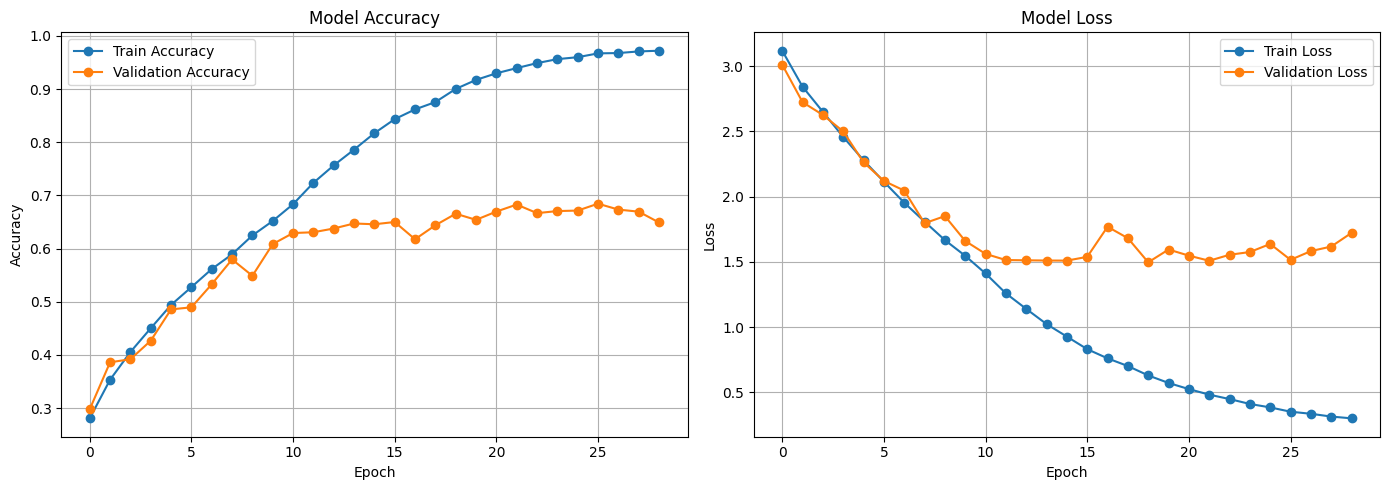

In [16]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Transfer Learning

In [15]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

### VGG16 Transfer Learning

In [19]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [11]:
for layer in base_model.layers:
    layer.trainable = False

# Add custom head
x = base_model.output
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
# x = Dropout(0.5)(x)
predictions = Dense(9, activation='softmax')(x)

In [12]:
model = Model(inputs=base_model.input, outputs=predictions)

In [13]:
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         9,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,415,049 (154.17 MB)

 Trainable params: 25,700,361 (98.04 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [16]:
# Setup directory to save best model
checkpoint_path = "transfer_best_model.h5"
callbacks = [
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    )
]

# Train the model with callbacks
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)



Epoch 1/30


/home/sanil/tensorflow/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746380734.522621    1783 service.cc:152] XLA service 0x7f263c00c240 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746380734.522666    1783 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2025-05-04 17:45:34.574336: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1746380734.863748    1783 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-04 17:45:36.023095: I external/local_x

  2/675 ━━━━━━━━━━━━━━━━━━━━ 44s 66ms/step - accuracy: 0.1641 - loss: 2.6208   

I0000 00:00:1746380744.683497    1783 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3242 - loss: 1.8816

2025-05-04 17:46:37.867987: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_220', 4 bytes spill stores, 4 bytes spill loads

2025-05-04 17:46:37.956735: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_220', 148 bytes spill stores, 148 bytes spill loads

2025-05-04 17:46:38.020164: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_220', 8 bytes spill stores, 8 bytes spill loads

2025-05-04 17:46:38.199053: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_220', 248 bytes spill stores, 248 bytes spill loads

2025-05-04 17:46:38.363434: I external/local


Epoch 1: val_loss improved from inf to 1.45565, saving model to transfer_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 70s 88ms/step - accuracy: 0.3242 - loss: 1.8813 - val_accuracy: 0.4770 - val_loss: 1.4557
Epoch 2/30
670/675 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5046 - loss: 1.3802
Epoch 2: val_loss improved from 1.45565 to 1.34561, saving model to transfer_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 53s 79ms/step - accuracy: 0.5047 - loss: 1.3800 - val_accuracy: 0.5193 - val_loss: 1.3456
Epoch 3/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5711 - loss: 1.2057
Epoch 3: val_loss improved from 1.34561 to 1.30124, saving model to transfer_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 53s 79ms/step - accuracy: 0.5711 - loss: 1.2057 - val_accuracy: 0.5357 - val_loss: 1.3012
Epoch 4/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.6054 - loss: 1.1044
Epoch 4: val_loss did not improve from 1.30124
675/675 ━━━━━━━━━━━━━━━━━━━━ 54s 80ms/step - accuracy: 0.6054 - loss: 1.1044 - val_accuracy: 0.5157 - val_loss: 1.3998
Epoch 5/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6376 - loss: 1.0188
Epoch 5: val_loss improved from 1.30124 to 1.24066, saving model to transfer_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 53s 79ms/step - accuracy: 0.6377 - loss: 1.0188 - val_accuracy: 0.5548 - val_loss: 1.2407
Epoch 6/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6747 - loss: 0.9273
Epoch 6: val_loss did not improve from 1.24066
675/675 ━━━━━━━━━━━━━━━━━━━━ 52s 77ms/step - accuracy: 0.6747 - loss: 0.9273 - val_accuracy: 0.5417 - val_loss: 1.2603
Epoch 7/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7040 - loss: 0.8465
Epoch 7: val_loss improved from 1.24066 to 1.20399, saving model to transfer_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 53s 79ms/step - accuracy: 0.7040 - loss: 0.8465 - val_accuracy: 0.5711 - val_loss: 1.2040
Epoch 8/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7301 - loss: 0.7791
Epoch 8: val_loss did not improve from 1.20399
675/675 ━━━━━━━━━━━━━━━━━━━━ 55s 81ms/step - accuracy: 0.7301 - loss: 0.7791 - val_accuracy: 0.5402 - val_loss: 1.2765
Epoch 9/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7403 - loss: 0.7620
Epoch 9: val_loss did not improve from 1.20399
675/675 ━━━━━━━━━━━━━━━━━━━━ 53s 78ms/step - accuracy: 0.7403 - loss: 0.7620 - val_accuracy: 0.5313 - val_loss: 1.3534
Epoch 10/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.7567 - loss: 0.7147
Epoch 10: val_loss did not improve from 1.20399
675/675 ━━━━━━━━━━━━━━━━━━━━ 53s 79ms/step - accuracy: 0.7567 - loss: 0.7147 - val_accuracy: 0.5648 - val_loss: 1.2884
Epoch 11/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7839 - loss: 0.6427
Epoch 11: val_loss did not impro

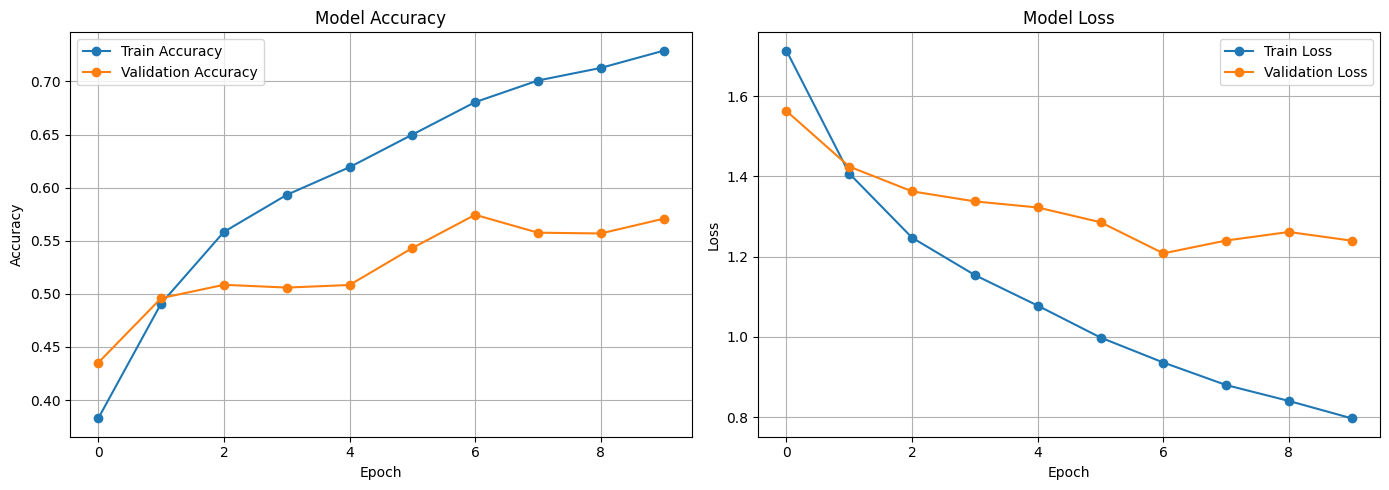

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Resnet Transfer Learning

In [16]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.layers import GlobalAveragePooling2D

# Load ResNet152V2 without the top classification layer
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Add custom classification layers on top
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(train_generator.num_classes, activation='softmax')(x)

# Define the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 58,858,505 (224.53 MB)

 Trainable params: 526,857 (2.01 MB)

 Non-trainable params: 58,331,648 (222.52 MB)

In [24]:
# Setup directory to save best model
checkpoint_path = "resnet_best_model.h5"
callbacks = [
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    )
]

# Train the model with callbacks
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=30,
    callbacks=callbacks
)



Epoch 1/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.2068 - loss: 2.2466

2025-05-04 18:11:07.524612: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4454', 204 bytes spill stores, 204 bytes spill loads

2025-05-04 18:11:07.792574: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4454_0', 396 bytes spill stores, 2300 bytes spill loads

2025-05-04 18:11:08.148891: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4454', 3940 bytes spill stores, 3920 bytes spill loads

2025-05-04 18:11:08.275927: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4454', 992 bytes spill stores, 992 bytes spill loads

2025-05-04 18:11:27.001795:


Epoch 1: val_loss improved from inf to 1.64614, saving model to resnet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 119s 144ms/step - accuracy: 0.2068 - loss: 2.2463 - val_accuracy: 0.4163 - val_loss: 1.6461
Epoch 2/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.3618 - loss: 1.7597
Epoch 2: val_loss improved from 1.64614 to 1.53707, saving model to resnet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 77s 113ms/step - accuracy: 0.3618 - loss: 1.7597 - val_accuracy: 0.4469 - val_loss: 1.5371
Epoch 3/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.4001 - loss: 1.6438
Epoch 3: val_loss improved from 1.53707 to 1.47721, saving model to resnet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 78s 115ms/step - accuracy: 0.4001 - loss: 1.6438 - val_accuracy: 0.4639 - val_loss: 1.4772
Epoch 4/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.4135 - loss: 1.6015
Epoch 4: val_loss improved from 1.47721 to 1.43450, saving model to resnet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 76s 113ms/step - accuracy: 0.4135 - loss: 1.6015 - val_accuracy: 0.4778 - val_loss: 1.4345
Epoch 5/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.4302 - loss: 1.5494
Epoch 5: val_loss improved from 1.43450 to 1.38148, saving model to resnet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 78s 116ms/step - accuracy: 0.4302 - loss: 1.5494 - val_accuracy: 0.5056 - val_loss: 1.3815
Epoch 6/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.4513 - loss: 1.5083
Epoch 6: val_loss improved from 1.38148 to 1.35789, saving model to resnet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 77s 114ms/step - accuracy: 0.4513 - loss: 1.5082 - val_accuracy: 0.5069 - val_loss: 1.3579
Epoch 7/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.4612 - loss: 1.4796
Epoch 7: val_loss improved from 1.35789 to 1.33924, saving model to resnet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 78s 115ms/step - accuracy: 0.4612 - loss: 1.4796 - val_accuracy: 0.5228 - val_loss: 1.3392
Epoch 8/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4602 - loss: 1.4622
Epoch 8: val_loss improved from 1.33924 to 1.31682, saving model to resnet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 75s 111ms/step - accuracy: 0.4602 - loss: 1.4622 - val_accuracy: 0.5272 - val_loss: 1.3168
Epoch 9/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4811 - loss: 1.4247
Epoch 9: val_loss improved from 1.31682 to 1.29917, saving model to resnet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 76s 113ms/step - accuracy: 0.4811 - loss: 1.4247 - val_accuracy: 0.5376 - val_loss: 1.2992
Epoch 10/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.4799 - loss: 1.4162
Epoch 10: val_loss improved from 1.29917 to 1.28986, saving model to resnet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 76s 112ms/step - accuracy: 0.4799 - loss: 1.4162 - val_accuracy: 0.5426 - val_loss: 1.2899
Epoch 11/30
665/675 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.4863 - loss: 1.4043
Epoch 11: val_loss improved from 1.28986 to 1.27936, saving model to resnet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 77s 114ms/step - accuracy: 0.4863 - loss: 1.4042 - val_accuracy: 0.5481 - val_loss: 1.2794
Epoch 12/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.4952 - loss: 1.3741
Epoch 12: val_loss improved from 1.27936 to 1.26070, saving model to resnet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 75s 111ms/step - accuracy: 0.4952 - loss: 1.3741 - val_accuracy: 0.5448 - val_loss: 1.2607
Epoch 13/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5037 - loss: 1.3602
Epoch 13: val_loss improved from 1.26070 to 1.23948, saving model to resnet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 77s 113ms/step - accuracy: 0.5036 - loss: 1.3602 - val_accuracy: 0.5596 - val_loss: 1.2395
Epoch 14/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5107 - loss: 1.3295
Epoch 14: val_loss improved from 1.23948 to 1.23276, saving model to resnet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 78s 115ms/step - accuracy: 0.5107 - loss: 1.3295 - val_accuracy: 0.5578 - val_loss: 1.2328
Epoch 15/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5078 - loss: 1.3343
Epoch 15: val_loss improved from 1.23276 to 1.21974, saving model to resnet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 75s 111ms/step - accuracy: 0.5078 - loss: 1.3343 - val_accuracy: 0.5650 - val_loss: 1.2197
Epoch 16/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5205 - loss: 1.3178
Epoch 16: val_loss improved from 1.21974 to 1.20160, saving model to resnet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 77s 114ms/step - accuracy: 0.5205 - loss: 1.3178 - val_accuracy: 0.5730 - val_loss: 1.2016
Epoch 17/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5144 - loss: 1.3278
Epoch 17: val_loss improved from 1.20160 to 1.19234, saving model to resnet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 75s 111ms/step - accuracy: 0.5144 - loss: 1.3277 - val_accuracy: 0.5737 - val_loss: 1.1923
Epoch 18/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5288 - loss: 1.2815
Epoch 18: val_loss improved from 1.19234 to 1.18273, saving model to resnet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 77s 115ms/step - accuracy: 0.5287 - loss: 1.2815 - val_accuracy: 0.5796 - val_loss: 1.1827
Epoch 19/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5380 - loss: 1.2740
Epoch 19: val_loss improved from 1.18273 to 1.18105, saving model to resnet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 76s 113ms/step - accuracy: 0.5380 - loss: 1.2740 - val_accuracy: 0.5780 - val_loss: 1.1810
Epoch 20/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5373 - loss: 1.2684
Epoch 20: val_loss improved from 1.18105 to 1.16545, saving model to resnet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 77s 114ms/step - accuracy: 0.5373 - loss: 1.2684 - val_accuracy: 0.5804 - val_loss: 1.1655
Epoch 21/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5477 - loss: 1.2388
Epoch 21: val_loss improved from 1.16545 to 1.15827, saving model to resnet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 75s 111ms/step - accuracy: 0.5477 - loss: 1.2389 - val_accuracy: 0.5856 - val_loss: 1.1583
Epoch 22/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5501 - loss: 1.2472
Epoch 22: val_loss improved from 1.15827 to 1.15387, saving model to resnet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 77s 114ms/step - accuracy: 0.5501 - loss: 1.2472 - val_accuracy: 0.5883 - val_loss: 1.1539
Epoch 23/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5388 - loss: 1.2449
Epoch 23: val_loss improved from 1.15387 to 1.14428, saving model to resnet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 75s 111ms/step - accuracy: 0.5388 - loss: 1.2448 - val_accuracy: 0.5904 - val_loss: 1.1443
Epoch 24/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5583 - loss: 1.2223
Epoch 24: val_loss improved from 1.14428 to 1.14094, saving model to resnet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 77s 114ms/step - accuracy: 0.5583 - loss: 1.2223 - val_accuracy: 0.5976 - val_loss: 1.1409
Epoch 25/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step - accuracy: 0.5553 - loss: 1.2193
Epoch 25: val_loss improved from 1.14094 to 1.13381, saving model to resnet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 75s 111ms/step - accuracy: 0.5553 - loss: 1.2193 - val_accuracy: 0.5935 - val_loss: 1.1338
Epoch 26/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5530 - loss: 1.2137
Epoch 26: val_loss improved from 1.13381 to 1.12387, saving model to resnet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 77s 114ms/step - accuracy: 0.5530 - loss: 1.2137 - val_accuracy: 0.5952 - val_loss: 1.1239
Epoch 27/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5587 - loss: 1.1993
Epoch 27: val_loss improved from 1.12387 to 1.11020, saving model to resnet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 77s 112ms/step - accuracy: 0.5587 - loss: 1.1993 - val_accuracy: 0.6043 - val_loss: 1.1102
Epoch 28/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5625 - loss: 1.1998
Epoch 28: val_loss did not improve from 1.11020
675/675 ━━━━━━━━━━━━━━━━━━━━ 76s 112ms/step - accuracy: 0.5625 - loss: 1.1998 - val_accuracy: 0.6026 - val_loss: 1.1141
Epoch 29/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step - accuracy: 0.5620 - loss: 1.2038
Epoch 29: val_loss improved from 1.11020 to 1.10314, saving model to resnet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 76s 113ms/step - accuracy: 0.5620 - loss: 1.2037 - val_accuracy: 0.6061 - val_loss: 1.1031
Epoch 30/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5708 - loss: 1.1829
Epoch 30: val_loss improved from 1.10314 to 1.10254, saving model to resnet_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 77s 114ms/step - accuracy: 0.5708 - loss: 1.1829 - val_accuracy: 0.6019 - val_loss: 1.1025
Restoring model weights from the end of the best epoch: 30.


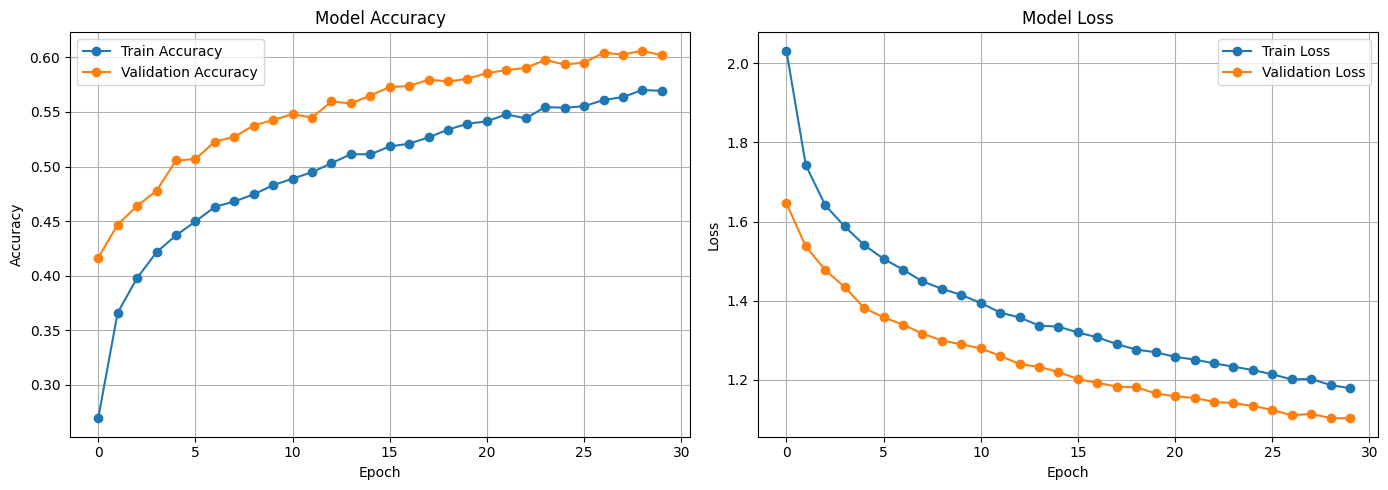

In [25]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Unfreeze deeper layers in Resnet and fine tune

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-10]:
    layer.trainable = False

# Setup directory to save best model
checkpoint_path = "resnet_fineTuned_best_model.h5"
callbacks = [
    ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    )
]

# Re-compile with a lower learning rate
model.compile(optimizer=Adam(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Fine-tuning
fine_tune_history = model.fit(
    train_generator,
    epochs=30,
    validation_data=val_generator, 
    callbacks=callbacks
)

Epoch 1/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.1768 - loss: 2.2921

2025-05-10 12:27:49.852081: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4454', 204 bytes spill stores, 204 bytes spill loads

2025-05-10 12:27:50.330985: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4454_0', 396 bytes spill stores, 2300 bytes spill loads

2025-05-10 12:27:50.806186: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4454', 3940 bytes spill stores, 3920 bytes spill loads

2025-05-10 12:27:51.147140: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4454', 992 bytes spill stores, 992 bytes spill loads

2025-05-10 12:28:11.385993:


Epoch 1: val_loss improved from inf to 1.75007, saving model to resnet_fineTuned_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 159s 186ms/step - accuracy: 0.1768 - loss: 2.2919 - val_accuracy: 0.3846 - val_loss: 1.7501
Epoch 2/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.3628 - loss: 1.7469
Epoch 2: val_loss improved from 1.75007 to 1.37726, saving model to resnet_fineTuned_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 100s 147ms/step - accuracy: 0.3629 - loss: 1.7468 - val_accuracy: 0.5035 - val_loss: 1.3773
Epoch 3/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.5026 - loss: 1.3849
Epoch 3: val_loss improved from 1.37726 to 1.16149, saving model to resnet_fineTuned_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 99s 147ms/step - accuracy: 0.5026 - loss: 1.3848 - val_accuracy: 0.5843 - val_loss: 1.1615
Epoch 4/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.5806 - loss: 1.1515
Epoch 4: val_loss improved from 1.16149 to 1.02053, saving model to resnet_fineTuned_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 100s 148ms/step - accuracy: 0.5806 - loss: 1.1514 - val_accuracy: 0.6337 - val_loss: 1.0205
Epoch 5/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6633 - loss: 0.9231
Epoch 5: val_loss improved from 1.02053 to 0.93152, saving model to resnet_fineTuned_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 101s 149ms/step - accuracy: 0.6633 - loss: 0.9231 - val_accuracy: 0.6639 - val_loss: 0.9315
Epoch 6/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.7301 - loss: 0.7465
Epoch 6: val_loss improved from 0.93152 to 0.87615, saving model to resnet_fineTuned_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 103s 152ms/step - accuracy: 0.7301 - loss: 0.7465 - val_accuracy: 0.6946 - val_loss: 0.8761
Epoch 7/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.7935 - loss: 0.5793
Epoch 7: val_loss improved from 0.87615 to 0.86684, saving model to resnet_fineTuned_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 102s 151ms/step - accuracy: 0.7935 - loss: 0.5792 - val_accuracy: 0.7013 - val_loss: 0.8668
Epoch 8/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8493 - loss: 0.4294
Epoch 8: val_loss improved from 0.86684 to 0.85802, saving model to resnet_fineTuned_best_model.h5


675/675 ━━━━━━━━━━━━━━━━━━━━ 100s 146ms/step - accuracy: 0.8493 - loss: 0.4294 - val_accuracy: 0.7128 - val_loss: 0.8580
Epoch 9/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8934 - loss: 0.3046
Epoch 9: val_loss did not improve from 0.85802
675/675 ━━━━━━━━━━━━━━━━━━━━ 98s 145ms/step - accuracy: 0.8934 - loss: 0.3046 - val_accuracy: 0.7148 - val_loss: 0.9214
Epoch 10/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.9335 - loss: 0.2065
Epoch 10: val_loss did not improve from 0.85802
675/675 ━━━━━━━━━━━━━━━━━━━━ 99s 146ms/step - accuracy: 0.9335 - loss: 0.2065 - val_accuracy: 0.7191 - val_loss: 0.9425
Epoch 11/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9554 - loss: 0.1386
Epoch 11: val_loss did not improve from 0.85802
675/675 ━━━━━━━━━━━━━━━━━━━━ 99s 147ms/step - accuracy: 0.9554 - loss: 0.1385 - val_accuracy: 0.7224 - val_loss: 1.0223
Epoch 12/30
675/675 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9730 - loss: 0.0905
Epoch 12: val_loss di

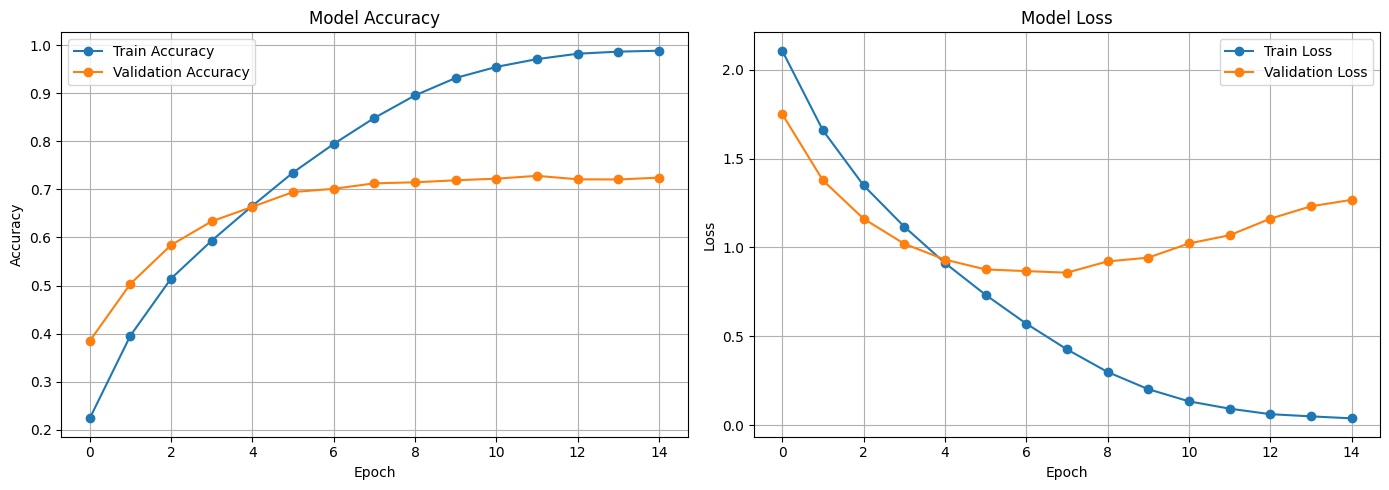

In [18]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(fine_tune_history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(fine_tune_history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(fine_tune_history.history['loss'], label='Train Loss', marker='o')
plt.plot(fine_tune_history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## Testing With Test Data

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model_on_test_data(test_dir, model_path, img_height=224, img_width=224, batch_size=32):
    """
    Evaluate a single model on a test dataset.

    Parameters:
    - test_dir (str): Path to the test dataset directory.
    - model_path (str): File path to the saved model.
    - img_height (int): Height of the input images (default: 224).
    - img_width (int): Width of the input images (default: 224).
    - batch_size (int): Batch size for the test data generator (default: 32).

    Returns:
    - None: Prints evaluation metrics for the model.
    """
    # Preprocess the test dataset
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False  # Ensure the order of predictions matches the test data
    )

    # Load the model
    model = load_model(model_path)

    # Evaluate the model
    print(f"\nEvaluating model: {model_path}...")
    loss, accuracy = model.evaluate(test_generator, verbose=1)
    print(f"Model - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

    # Generate predictions
    predictions = model.predict(test_generator)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes
    class_labels = list(test_generator.class_indices.keys())

    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(true_classes, predicted_classes, target_names=class_labels))

    # Confusion matrix
    print(f"\nConfusion Matrix:")
    print(confusion_matrix(true_classes, predicted_classes))

test_dir = 'SkinCancerClassification/Test'
model_path = "skin_cancer_baseline_model2.h5"  

evaluate_model_on_test_data(test_dir, model_path)

Found 118 images belonging to 9 classes.


/home/sanil/py3.11-tensorflow/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Evaluating model: skin_cancer_baseline_model2.h5...
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 800ms/step - accuracy: 0.3708 - loss: 2.0788
Model - Loss: 1.9449, Accuracy: 0.4322
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 817ms/step

Classification Report:
                            precision    recall  f1-score   support

         actinic keratosis       0.75      0.19      0.30        16
      basal cell carcinoma       0.55      0.38      0.44        16
            dermatofibroma       0.55      0.38      0.44        16
                  melanoma       0.14      0.06      0.09        16
                     nevus       0.47      1.00      0.64        16
pigmented benign keratosis       0.31      0.75      0.44        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.80      0.25      0.38        16
           vascular lesion       0.60      1.00      0.75         3

                  accuracy                           0.43       118
                 macro

In [19]:
model_path = "skin_cancer_fine_tuned_model2.h5"  

evaluate_model_on_test_data(test_dir, model_path)

Found 118 images belonging to 9 classes.


/home/sanil/py3.11-tensorflow/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Evaluating model: skin_cancer_fine_tuned_model2.h5...
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 777ms/step - accuracy: 0.3763 - loss: 2.9293
Model - Loss: 2.7424, Accuracy: 0.4068
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 770ms/step

Classification Report:
                            precision    recall  f1-score   support

         actinic keratosis       0.40      0.25      0.31        16
      basal cell carcinoma       0.55      0.38      0.44        16
            dermatofibroma       0.62      0.50      0.55        16
                  melanoma       0.20      0.06      0.10        16
                     nevus       0.36      1.00      0.52        16
pigmented benign keratosis       0.38      0.56      0.45        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.17      0.06      0.09        16
           vascular lesion       0.75      1.00      0.86         3

                  accuracy                           0.41       118
                 mac

/home/sanil/py3.11-tensorflow/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sanil/py3.11-tensorflow/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sanil/py3.11-tensorflow/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r

In [20]:
model_path = "transfer_best_model.h5"  

evaluate_model_on_test_data(test_dir, model_path)

Found 118 images belonging to 9 classes.


/home/sanil/py3.11-tensorflow/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Evaluating model: transfer_best_model.h5...
4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 793ms/step - accuracy: 0.4033 - loss: 1.9285
Model - Loss: 1.8605, Accuracy: 0.3729
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 798ms/step

Classification Report:
                            precision    recall  f1-score   support

         actinic keratosis       0.67      0.38      0.48        16
      basal cell carcinoma       0.42      0.50      0.46        16
            dermatofibroma       0.35      0.56      0.43        16
                  melanoma       0.21      0.31      0.25        16
                     nevus       0.40      0.38      0.39        16
pigmented benign keratosis       0.27      0.25      0.26        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.60      0.19      0.29        16
           vascular lesion       1.00      1.00      1.00         3

                  accuracy                           0.37       118
                 macro avg    

In [21]:
model_path = "resnet_best_model.h5"  

evaluate_model_on_test_data(test_dir, model_path)

Found 118 images belonging to 9 classes.


/home/sanil/py3.11-tensorflow/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Evaluating model: resnet_best_model.h5...
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.3700 - loss: 1.9944
Model - Loss: 1.8643, Accuracy: 0.3729
4/4 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step 

Classification Report:
                            precision    recall  f1-score   support

         actinic keratosis       0.83      0.31      0.45        16
      basal cell carcinoma       0.30      0.38      0.33        16
            dermatofibroma       0.42      0.62      0.50        16
                  melanoma       0.21      0.19      0.20        16
                     nevus       0.33      0.62      0.43        16
pigmented benign keratosis       0.27      0.19      0.22        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       0.57      0.25      0.35        16
           vascular lesion       0.60      1.00      0.75         3

                  accuracy                           0.37       118
                 macro avg       0.

In [23]:
model_path = "resnet_fineTuned_best_model.h5"  

evaluate_model_on_test_data(test_dir, model_path)

Found 118 images belonging to 9 classes.


/home/sanil/py3.11-tensorflow/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()



Evaluating model: resnet_fineTuned_best_model.h5...
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - accuracy: 0.5289 - loss: 2.0262
Model - Loss: 2.1487, Accuracy: 0.4915
4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step 

Classification Report:
                            precision    recall  f1-score   support

         actinic keratosis       0.62      0.31      0.42        16
      basal cell carcinoma       0.54      0.94      0.68        16
            dermatofibroma       0.69      0.56      0.62        16
                  melanoma       0.25      0.12      0.17        16
                     nevus       0.41      0.81      0.54        16
pigmented benign keratosis       0.39      0.56      0.46        16
      seborrheic keratosis       0.00      0.00      0.00         3
   squamous cell carcinoma       1.00      0.12      0.22        16
           vascular lesion       1.00      1.00      1.00         3

                  accuracy                           0.49       118
                 macro av